### *A* | *B* Testing Using MCMC and PyMC3

Probably not a good choice for now. Development for Theano, PyMC3's backend, came to end this past October. PyMC devs are exploring other backends (PyTorch, MXNet, TensorFlow/probability), but so far there is only one script testing a backend (PyTorch) in the the PyMC4 prototype repo.

Stan (via PyStan or RStan) or the greta R package (with TensorFlow backend) may be better long-run probablistic programming / Bayesian modeling toolkits. 

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
from scipy.optimize import fmin_powell


%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
true_pA = 0.05
true_pB = 0.055


nA = 20000
nB = 20000

#generate some observations
observations_A = stats.bernoulli.rvs(true_pA, size=nA)
observations_B = stats.bernoulli.rvs(true_pB, size=nB)

In [3]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.0486
0.05455


In [4]:
# Set up the pymc3 model. Again assume Uniform priors for pA and pB.

with pm.Model() as model:
    pA = pm.Uniform("pA", 0, 1)
    pB = pm.Uniform("pB", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", pB - pA)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", pA, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", pB, observed=observations_B)

    # Use Powell's Method from scipy.optimize for MAP estimation
    start = pm.find_MAP(fmin=fmin_powell)
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step, start=start)
    # Toss burn in samples
    burned_trace=trace[5000:]

/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -8,263.6:   1%|          | 40/5000 [00:00<00:02, 1980.10it/s]

Optimization terminated successfully.
         Current function value: 8121.454464
         Iterations: 2
         Function evaluations: 47


logp = -8,263.6:   1%|          | 47/5000 [00:01<01:47, 46.28it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pB_interval__]
>Metropolis: [pA_interval__]
100%|██████████| 25500/25500 [00:20<00:00, 1269.28it/s]
The number of effective samples is smaller than 25% for some parameters.


In [5]:
pA_samples = burned_trace["pA"]
pB_samples = burned_trace["pB"]
delta_samples = burned_trace["delta"]

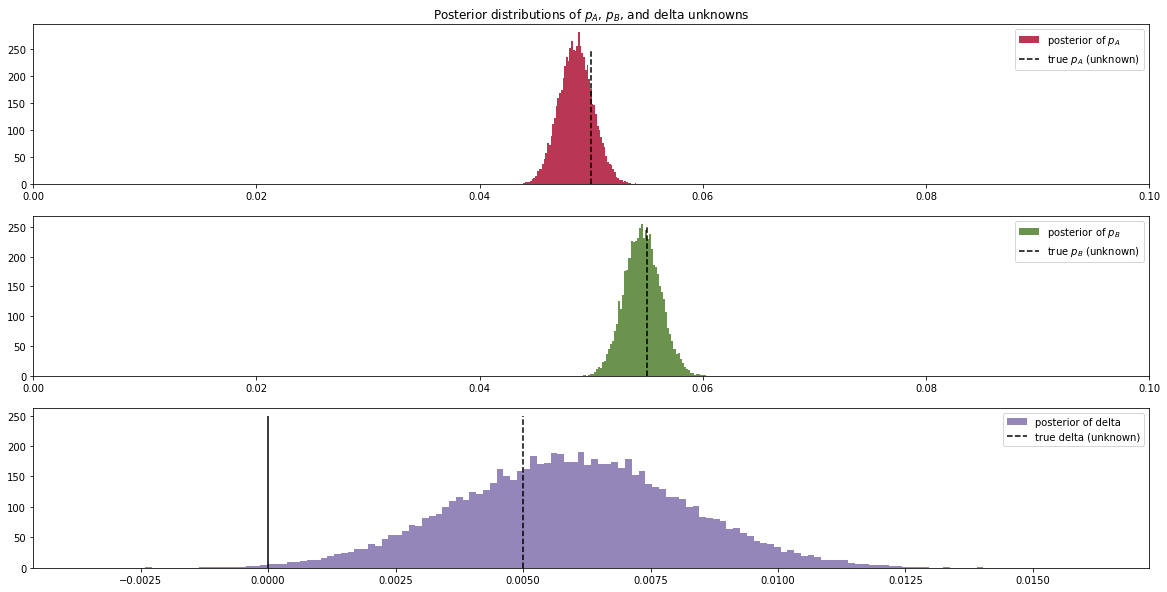

In [6]:
# Histogram of posteriors

figsize(20, 10)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(pA_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_pA, 0, 250, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(pB_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_pB, 0, 250, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.hist(delta_samples, histtype='stepfilled', bins=150, alpha=0.80,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_pB - true_pA, 0, 250, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 250, color="black", alpha=1)
plt.legend(loc="upper right");

In [7]:
# Probability that site A is worse than site B.

print("Probability site B is WORSE than site A: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site B is BETTER than site A: %.3f" % \
    np.mean(delta_samples > 0))

Probability site B is WORSE than site A: 0.003
Probability site B is BETTER than site A: 0.997


In [8]:
# Credible Interval, alpha = .05

pm.stats.hpd(delta_samples, alpha=0.05)

array([0.00161801, 0.01028422])